# Gaussian Process Regression Models

In this notebook, we will learn how to use a Gaussian Process Regression model to predict the energy and gradient of points on the Mueller-Brown potential energy surface.

We will again start by defining the function for the Mueller-Brown potnetial energy surface:

$$v(x,y) = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2]$$

We will also define the derivatives with respect to $x$ and $y$ for the Muller-Brown potential energy surface:

$$\frac{dv(x,y)}{dx} = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [2a_k(x-x_k^0) + b_k(y-y_k^0)]$$

$$\frac{dv(x,y)}{dy} = \sum_{k=0}^{3} A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [b_k(x-x_k^0) + 2c_k(y-y_k^0)]$$

In [1]:
import IPython
print(IPython.__version__)

import sys
print(sys.executable)

import sys
sys.path.append("src")
from math import exp, pow
import numpy as np
from matplotlib import pyplot as plt

from gpr_pes import ExactGPModel, GPMoldeWithDerivatives
from gpr_pes import plot_contour
from gpr_pes import train_model

%load_ext IPython.extensions.autoreload
%autoreload 2

def mueller_brown_potential_with_gradient(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1.0]
    y0 = [0, 0.5, 1.5, 1]
    z = 0
    dx = 0
    dy = 0
    for k in range(4):
        # Scale the function by 0.1 to make plotting easier
        z += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2))
        dx += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (a[k] * 2 *(x-x0[k]) + b[k] * (y-y0[k]))
        dy += 0.1 * A[k] * exp(a[k] * pow(x-x0[k], 2) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2)) * (b[k] * (x-x0[k])+ c[k] * 2 * (y-y0[k]))
    return z, dx, dy

8.38.0
/Users/dipteshgayen/anaconda3/envs/MLP/bin/python3.10


## Generating Training Data

In [2]:
# generate x and y on a grid
x_range = np.arange(-1.8, 1.4, 0.1, dtype=np.float32)
y_range = np.arange(-0.4, 2.4, 0.1, dtype=np.float32)
X, Y = np.meshgrid(x_range, y_range)

# Compute the potential energy at each point on the grid
mueller_brown_potential_with_gradient_vectorized = np.vectorize(mueller_brown_potential_with_gradient, otypes=[np.float32, np.float32, np.float32])
Z, dX, dY = mueller_brown_potential_with_gradient_vectorized(X, Y)

# Keep only low-energy points for training
train_mask = Z < 10
X_train, Y_train, Z_train, dX_train, dY_train = X[train_mask], Y[train_mask], Z[train_mask], dX[train_mask], dY[train_mask]


print(f"Shape of X: {X_train.shape}")
print(f"Shape of Y: {Y_train.shape}")
print(f"Shape of Z: {Z_train.shape}")
print(f"Shape of dX: {dX_train.shape}")
print(f"Shape of dY: {dY_train.shape}")
print(f"Z_min: {min(Z_train)}")
print(f"Z_max: {max(Z_train)}")

Shape of X: (696,)
Shape of Y: (696,)
Shape of Z: (696,)
Shape of dX: (696,)
Shape of dY: (696,)
Z_min: -14.599801063537598
Z_max: 9.83088493347168


## Visualizing Training Data: 3D Projection Surface

We now create 3D plot of our training data.

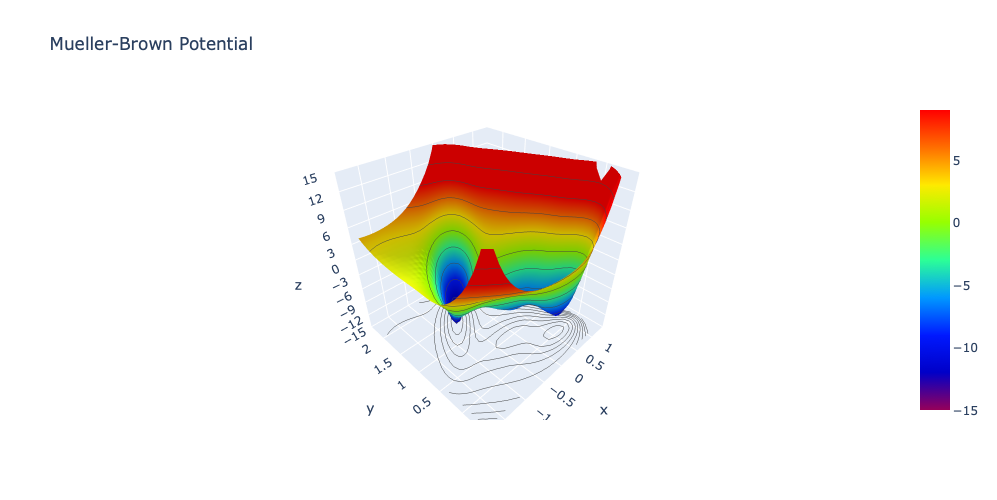

In [3]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale="rainbow", cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title="Mueller-Brown Potential",
                 width=500,
                 height=500,
                 scene=dict(zaxis=dict(dtick=3, range=[-15, 15]),
                 camera_eye = dict(x=-1.2, y=-1.2, z = 1.2)
                 ))

fig.show()


## Visualizing Training Data: Contour Surface

For a simple potential energy surface, we can generate 2D contour surface.

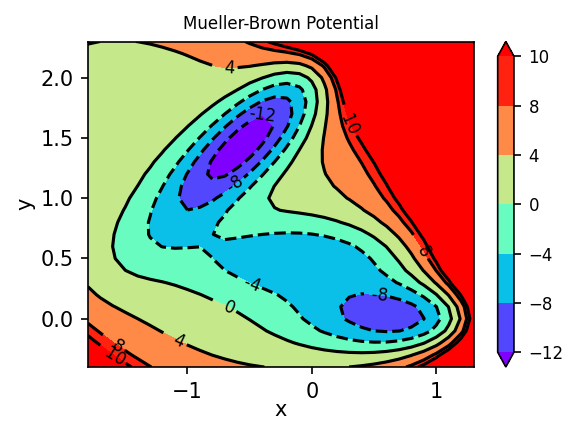

In [12]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
plot_contour(X, Y, Z, ax, title="Mueller-Brown Potential")
plt.tight_layout()
plt.savefig("Images/Mueller-Brown-Potential.png", dpi=1000)

## Loading PyTorch and GPyTorch for GPR Learning

GPyTorch is a Gaussian process library implemented using PyTorch. 

In [5]:
import torch 
import gpytorch

## Defining a GPR Model for Energy Prediction

First, we will learn how to use a GPR model to predict energies only.

Let us define the variables in our function using a vector of input features with $D$ observables as $\textbf{x} = [x_1, x_2, .., x_D]$. A set of $n$ confiugations can be assembled into a training set $\textbf{X} = [\textbf{x}_1,..,\textbf{x}_n]$ with a corresponding set of observations $\textbf{y} = [\textbf{y}_1,..,\textbf{y}_n]$.

For noisy samples, we can assume that an observation $y$ is seperate from the underlying function $f(\textbf{X})$ accroding to $y(\mathbf{X}) = f(\mathbf{X}) + \epsilon$, where the noise, $\epsilon$, follows a Gaussian distribution $\epsilon \sim \mathcal{N}(0, \sigma_n^2)$, where $\sigma_n^2$ is the noise parameter. The prior distribution of underlying functions follows a Gaussian distribution $f(\textbf{X}) \sim \mathcal{N}(0, \textbf{K(X, X)}$, where $\textbf{0}$ is the mean function and $K$ is the covariance kernel matrix. The covariance kernel matrix is assembled based on a kernel function, $k$, that measures the similarities between input vectors:

$$
K(\mathbf{X},\mathbf{X}) =
\begin{bmatrix}
k(x_1,x_1) & \cdots & k(x_1,x_n) \\
\vdots & \ddots & \vdots \\
k(x_n,x_1) & \cdots & k(x_n,x_n)
\end{bmatrix}
$$

Here we used the radial basis function:
$$k(x_a, x_b) = \sigma_f^2 \exp\Big(- \frac{||x_a - x_b||^2}{2l^2}\Big)$$

where $\sigma_f^2$ is the vertical variation parameter, and $l$ is the length parameter. 

In [6]:
# turn Numpy arrays into PyTorch tensors
X_gpr = torch.from_numpy(np.column_stack((X_train, Y_train)))
Z_gpr = torch.from_numpy(Z_train)

# Gaussian observation model:
# assumes measurements contain noise σ_n²
# This parameter is optimized by maximing marginal likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create GP model
# At this stage:
# - no training has occured
# - kernel hyperparameters are random
# Training will adjust them so the dataset is statistically likely
model = ExactGPModel(X_gpr, Z_gpr, likelihood)

## GPR Hyperparameters
With the noise hyperparameters $\sigma_n^2$, vertical variation parameter $\sigma_f^2$, and the length scale parameter $l$, we can define. 

$$\tilde{\textbf{K}} = \textbf{K(X, X)} + \sigma_n^2 \textbf{I}$$

with $I$ being the identity matrix. The set of hyperparameters $\Theta = {\sigma_f^2, l, \sigma_n^2}$ are optimized by maximizing the marginal likelihod. The marginal likelihood is defined as:

$$p(y|X, \Theta)$$

Because the latent function values $f$ are unknown, the gaussian probability integrates over all possible functions:

$$p(y|X, \Theta) = \int p(y|f) p(f|X, \Theta) df$$

The likelihood is a Gaussian:

$$p(y|X, \Theta) = \frac{1}{(2\pi)^{(n/2)}|\tilde{\textbf{K}}|^{1/2}} \exp\Big(-\frac{1}{2}y^T\tilde{\textbf{K}}^{-1}y\Big) $$

Optimization of products are unstable, so it is better to maximize:
$$\log p(y| X, \Theta),$$ which becomes:
$$ \log p(y|X, \Theta) = - \frac{1}{2}y^T\tilde{\textbf{K}}^{-1}y - \frac{1}{2}\log|\tilde{\textbf{K}}| - \frac{n}{2}\log(2\pi) $$

Now, optimization becomes additive and stable. 

## Hyperparameter likelihood surface exploration

Evaluate how the negative $\log$ marginal likelihood depends on the kernel hyperparameters. Instead of optimizing the hyperparameters, we scan them on a grid and compute:

$$L(\Theta) = -\log p(y | X, \Theta)$$

**Fixed parameters**
* $\sigma_n^2$ (noise vairance) = constant

**Varied parameters**
* $l$ -> lengthscale
* $\sigma_f^2$ -> output scale / signal variance (vertical aplitude)

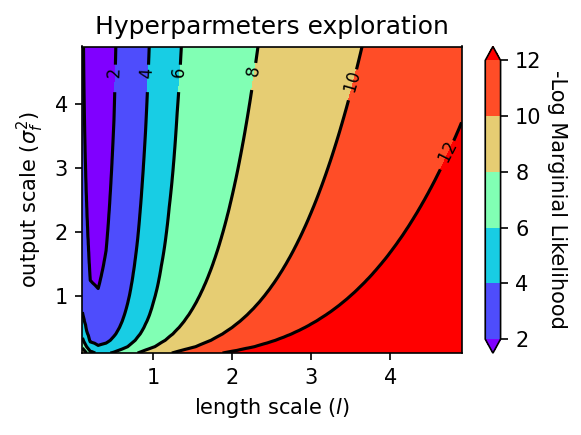

In [7]:
noise_value = 1.0 

# Create a grid in hyperparameters space
# l -> [0.1, 4.9]
# sigma_f^2 -> [0.1, 4.9]
scale_and_length = [[i*.1, j*.1] for i in range(1,50) for j in range(1, 50)]

# Storage for visualization of likelihood landscape
x_plt = []
y_plt = []
z_plt = []

for pair in scale_and_length:
    # Set GP hyperparameters manually
    # \Theta = {\sigma_n^2, l, \sigma_f^2}
    # We directly put them into the model instead of learning them via gradient descent. 
    hypers = {
        "likelihood.noise_covar.noise": torch.tensor(noise_value),
        "covar_module.base_kernel.lengthscale": torch.tensor(pair[0]),
        "covar_module.outputscale": torch.tensor(pair[1]),
    }

    model.initialize(**hypers)

    # Initialize the function for calculating the marginal likelihood log
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # computed prior predictive distribution at training inputs
    output = model(X_gpr)

    # Evaluate negative log marginal likelihood
    loss = -mll(output, Z_gpr)

    # Store results
    x_plt.append(pair[0])
    y_plt.append(pair[1])
    z_plt.append(loss.item())

fig = plt.figure(figsize=(4,3), dpi=150)
plt.subplot(1, 1, 1)
ct = plt.tricontour(x_plt, y_plt, z_plt, colors="k")
plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
ct = plt.tricontourf(x_plt, y_plt, z_plt, cmap=plt.cm.rainbow, extend="both")
plt.xlabel(r"length scale ($l$)")
plt.ylabel(r"output scale ($\sigma_f^2$)")
plt.colorbar().set_label("-Log Marginial Likelihood", rotation=270, labelpad=12)
plt.title("Hyperparmeters exploration")
plt.tight_layout()
plt.savefig("Images/hyperparmeters-exploration.png", dpi=1000)

## Training the Model

Now, we can train the model. We will start with initial values for our hyperparmeters ($\sigma_n^2$, $\sigma_f^2$, and $l$) and then optimize the hyperparameters until the desired number of iterations is reached. Then we will print the optimized hyperparmeters. 

In [8]:
# put the model and likelihood in training mode
model.train()
likelihood.train()

# Train model
train_model(model, likelihood, X_gpr, Z_gpr, print_hp=True)

--------------------------------------------------------------------
Parmeters name: likelihood.noise_covar.raw_noise           value =   0.54117
Parmeters name: covar_module.raw_outputscale               value =  -0.43275
Parmeters name: covar_module.base_kernel.raw_lengthscale   value =  -0.43275
--------------------------------------------------------------------
Iter:  10 | Loss: 2.224 | Output scale: 0.815 | Length scale: 0.277 | Noise: 1.047 
Iter:  20 | Loss: 1.956 | Output scale: 1.122 | Length scale: 0.265 | Noise: 0.963 
Iter:  30 | Loss: 1.786 | Output scale: 1.387 | Length scale: 0.261 | Noise: 0.856 
Iter:  40 | Loss: 1.655 | Output scale: 1.618 | Length scale: 0.260 | Noise: 0.742 
Iter:  50 | Loss: 1.539 | Output scale: 1.824 | Length scale: 0.259 | Noise: 0.628 
Iter:  60 | Loss: 1.428 | Output scale: 2.011 | Length scale: 0.259 | Noise: 0.519 
Iter:  70 | Loss: 1.318 | Output scale: 2.184 | Length scale: 0.259 | Noise: 0.420 
Iter:  80 | Loss: 1.206 | Output scale: 2.3

## Gaussian Process Prediction

After training, the Gaussian Process does not produce a single function. It produces a **predictive distribution over functions** at new input locations.  
For a new test point $x^*$, the predictive distribution is:
$$f(x^*) \sim \mathcal{N}(\sigma^*, \Sigma^*),$$ 
where:
$$\mu^* = K^*K^{-1}y$$
$$\Sigma^* = K^{**} - K^{*}K^{-1}K^{*T}$$

Definitions:
* $K = K(X, X) + \sigma_n^2 I$ (Training covariance matrix)
* $K^* = K(X, x^*)$ (Cross-covariance between training and test points)
* $K^{**} = K(x^*, x^*)$ (Covariance among test points)

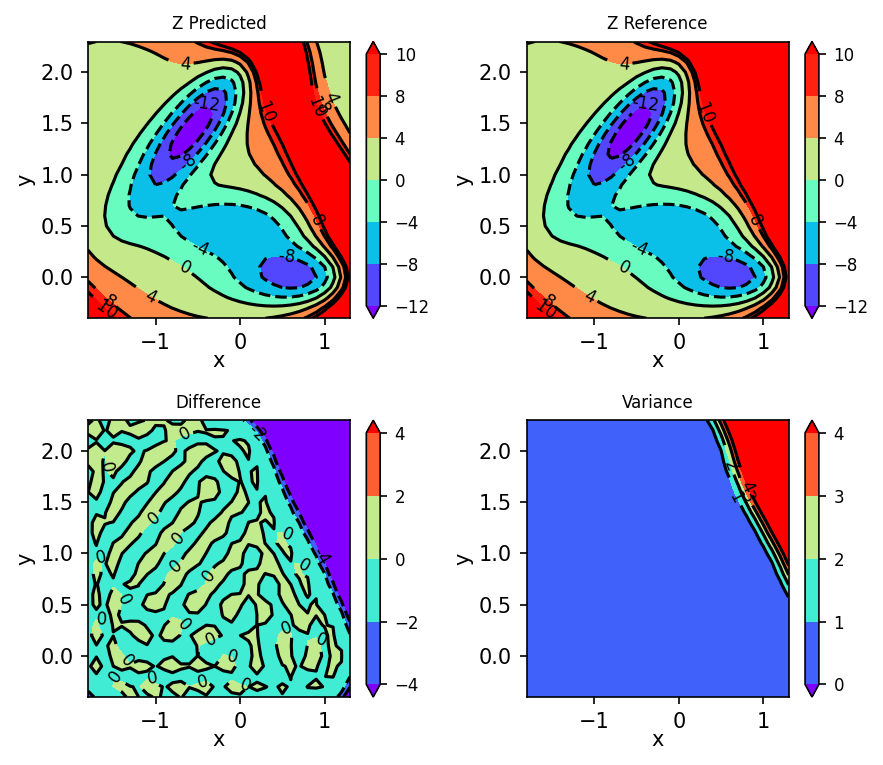

In [14]:
# Evaluation mode (it switches off the gradient compuation and fixes hyperparameters)
model.eval()
likelihood.eval()

# Compute GP predictive distribution over full grid
pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten()))))

# Posterior mean surface
Z_pred = pred.mean.detach().numpy().reshape(Z.shape)

# Posterior variance surface
Z_var = pred.variance.detach().numpy().reshape(Z.shape)

# Difference between GP 
Z_diff = Z_pred - Z


fig, ax = plt.subplots(2, 2, figsize=(6, 5.2), dpi=150)
plot_contour(X, Y, Z_pred, ax=ax[0, 0], title='Z Predicted')
plot_contour(X, Y, Z, ax=ax[0, 1], title='Z Reference')
plot_contour(X, Y, Z_diff, ax=ax[1, 0], title='Difference', levels=[-4, -2, 0, 2, 4])
plot_contour(X, Y, Z_var, ax=ax[1, 1], title='Variance', levels=[0, 1, 2, 3, 4])
fig.tight_layout()


## Using a GPR model to Predict Energies and Gradients

The Goal is to use GPR to predict:
* Energies
* Gradients (forces)

Let's recall the whole concept again. We have the input feature vectors:

$$X = [x_1, x_2, ..., x_n],$$ 

and observed outputs:

$$y = [y_1, y_2, ..., y_n]^T$$

Each $y_i$ is:
$$y_i = f(x_i) + \epsilon$$
where $\epsilon$ is noise. We don't know $f$, only thing we know that it is smooth function. 

Let's recall again the idea of the Gaussian process. Gaussian process does not assume a parametric model, instead it assumes: points that are close in input space have correlated outputs. This is correlation is encoded through a kernel functions, $k(x_i, x_j)$. The kernel function measures the similarity between two inputs. Then we build the covariance matrx:

$$
K(\mathbf{X},\mathbf{X}) =
\begin{bmatrix}
k(x_1,x_1) & \cdots & k(x_1,x_n) \\
\vdots & \ddots & \vdots \\
k(x_n,x_1) & \cdots & k(x_n,x_n)
\end{bmatrix}
$$

If $f(x)$ is a Guassian process, then its derivatives, $\frac{\partial f}{\partial x}$, are also Gaussian Processes (**Once a Gaussian, always a Gaussian**). This is critical. It means, we can train not only on energies, but also on gradients (forces). Therefore, they can be incorporated into the traiing targets and used to make explcit predictions of the gradeint:

$$y_ext = \Big[y_1, ....., y_n, \frac{\partial f(x_1) }{\partial x}, ....., \frac{\partial f(x_n) }{\partial x}, \frac{\partial f(x_1) }{\partial y}, ....., \frac{\partial f(x_1) }{\partial y} \Big]^T$$

To account for the additional observations, the extended kernel is: 

$$
\mathbf{K}(\mathbf{X},\mathbf{X}')
= \begin{bmatrix}
K(\mathbf{X},\mathbf{X}') 
& 
\frac{\partial K(\mathbf{X},\mathbf{X}')}{\partial \mathbf{X}'} \\
\frac{\partial K(\mathbf{X},\mathbf{X}')}{\partial \mathbf{X}} 
& 
\frac{\partial^2 K(\mathbf{X},\mathbf{X}')}{\partial \mathbf{X}\,\partial \mathbf{X}'}
\end{bmatrix}
$$

In [18]:
# Training data
X_gpr = torch.from_numpy(np.column_stack((X_train, Y_train)))
Z_gpr = torch.from_numpy(np.column_stack((Z_train, dX_train, dY_train)))

# Test data
X_test = torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))
Z_test = torch.from_numpy(np.column_stack((Z.flatten(), dX.flatten(), dY.flatten())))

print(f"----")
print(f"Shape of the X training: {X_gpr.shape}")
print(f"Shape of the Y training: {Z_gpr.shape}")
print(f"----")
print(f"Shape of the X test: {X_test.shape}")
print(f"Shape of the Y test: {Z_test.shape}")
print(f"----")

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3) # Value + x-derivative + y-derivative



----
Shape of the X training: torch.Size([696, 2])
Shape of the Y training: torch.Size([696, 3])
----
Shape of the X test: torch.Size([896, 2])
Shape of teh Y test: torch.Size([896, 3])
----
